Groups
Medcat outputs - dates from sources?
Foresight

Setup

In [1]:
# Import libraries
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from date_spacy import find_dates

Data

In [2]:
#Sample clinical note
clinical_note = """
InitialPresentation 15-01-2023[date]  
pt presents w severe HA x2/52,getting worse.no relief w/regular painkillers
imp: chronic migraine[diagnosis]vs tension headache[diagnosis]??? 
plan- start sumatriptan,f/u 2/52

URGENT REVIEW(20.01.23[date]):pt called- new onset visual symps.  
rapid worsening,Now with diplopia.urgent referral to ophth
-> ?pituitary mass vs IIH[diagnosis]

ophth notes(Jan 25th 2023[date])  
bilat papilloedema[diagnosis]+++
vf loss temp sides
urgent mri requested..   

radiology(02/02/2023 @1445[date])
findings:large sellar/suprasellar mass 2.8x3.1x2.9cm
imp:macroadenoma[diagnosis],severe mass effect
needs urgent endo r/v

endocrine assessment 3rd Feb'23[date]
hormonal panel results:
prolactin>2000
cortisol-low
imp:giant prolactinoma[diagnosis] w/partial hypopituitarism[diagnosis]
started cab 0.25mg 2x/wk
stress dose steroids given

f/u 17/2/23[date]-phone
HA better.no more diplopia
cont cab

clinic rv - 2023-03-15[date]
doing well.pro level down to 1500
vision improving
cont current rx

ENDO CLINIC(12 apr 23[date])
much improved
pro now 800
repeat MRI shows good response-tumor[diagnosis]shrinking
cont same dose

NOTE:15-5-2023[date]- pt called
mild n/v last 2/7
?adrenal insufficiency[diagnosis]
urgentbloods+short synacthen-booked 16/5

quick note 16/5/23[date]:synacthen confirms adrenal insufficiency[diagnosis]
starting hydrocort 10/5/5
"""

print(clinical_note)


InitialPresentation 15-01-2023[date]  
pt presents w severe HA x2/52,getting worse.no relief w/regular painkillers
imp: chronic migraine[diagnosis]vs tension headache[diagnosis]??? 
plan- start sumatriptan,f/u 2/52

URGENT REVIEW(20.01.23[date]):pt called- new onset visual symps.  
rapid worsening,Now with diplopia.urgent referral to ophth
-> ?pituitary mass vs IIH[diagnosis]

ophth notes(Jan 25th 2023[date])  
bilat papilloedema[diagnosis]+++
vf loss temp sides
urgent mri requested..   

radiology(02/02/2023 @1445[date])
findings:large sellar/suprasellar mass 2.8x3.1x2.9cm
imp:macroadenoma[diagnosis],severe mass effect
needs urgent endo r/v

endocrine assessment 3rd Feb'23[date]
hormonal panel results:
prolactin>2000
cortisol-low
imp:giant prolactinoma[diagnosis] w/partial hypopituitarism[diagnosis]
started cab 0.25mg 2x/wk
stress dose steroids given

f/u 17/2/23[date]-phone
HA better.no more diplopia
cont cab

clinic rv - 2023-03-15[date]
doing well.pro level down to 1500
vision imp

Condition Extraction

In [3]:
def diagnosis_ner(text):
    results = []

    # List of medical conditions to search for
    conditions = [
        "migraine", "headache", "pituitary adenoma", "prolactinoma", 
        "tumor", "cancer", "diabetes", "hypertension", "asthma"
    ]
    
    # Word matching
    for condition in conditions:
        pattern = re.compile(r'\b' + condition + r'\b', re.IGNORECASE)
        for match in pattern.finditer(text):
            start = match.start()
            diagnosis = match.group()
            results.append((diagnosis.lower(), start))
    
    # Look for diagnosis statements
    diagnosis_patterns = [
        r'Diagnosis:\s*([A-Za-z\s]+)',
        r'Diagnosed with\s*([A-Za-z\s]+)',
        r'indicates\s*([A-Za-z\s]+)'
    ]
    
    for pattern in diagnosis_patterns:
        for match in re.finditer(pattern, text):
            diagnosis_text = match.group(1).strip().lower()
            # Skip if too generic or empty
            if diagnosis_text and len(diagnosis_text) > 3:
                results.append((diagnosis_text, match.start(1)))
    
    return results

In [4]:
# Extract diagnoses
diagnoses = diagnosis_ner(clinical_note)
print("Extracted diagnoses:")
for diagnosis, position in diagnoses:
    print(f"- {diagnosis} (position: {position})")

diagnoses #List of (diagnosis, position) tuples

Extracted diagnoses:
- migraine (position: 129)
- headache (position: 159)
- prolactinoma (position: 752)
- tumor (position: 1110)


[('migraine', 129), ('headache', 159), ('prolactinoma', 752), ('tumor', 1110)]

Dates

In [5]:
def extract_dates(text):
    # Regex patterns for different date formats
    date_patterns = [
        # DD-MM-YYYY or DD.MM.YYYY or DD/MM/YYYY
        r'\b(\d{1,2})[-./](\d{1,2})[-./](20\d{2}|\d{2})\b',
        
        # Written format
        r'\b(\d{1,2}(?:st|nd|rd|th)?\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\'?\s*(?:20\d{2}|\d{2}))\b',
        
        # YYYY-MM-DD format
        r'\b(20\d{2})[-./](\d{1,2})[-./](\d{1,2})\b'
    ]
    
    dates = []
    
    for pattern in date_patterns:
        matches = re.finditer(pattern, text)
        for match in matches:
            date_str = match.group(0)
            position = match.start()
            
            try:
                # Try parsing the date string
                if re.match(r'\d{1,2}[-./]\d{1,2}[-./]', date_str):  # DD-MM-YYYY format
                    day, month, year = re.split(r'[-./]', date_str)
                    if len(year) == 2:
                        year = '20' + year
                
                elif re.match(r'20\d{2}[-./]\d{1,2}', date_str):  # YYYY-MM-DD format
                    year, month, day = re.split(r'[-./]', date_str)
                
                else:  # Written month format
                    # Extract components from written format
                    parts = date_str.lower().replace("'", " ").split()
                    # Handle day with suffix
                    day = re.sub(r'(?:st|nd|rd|th)', '', parts[0])
                    # Convert month name to number
                    month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                               'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
                    month = month_map[parts[1][:3].lower()]
                    # Handle year
                    year = parts[-1]
                    if len(year) == 2:
                        year = '20' + year
                
                # Create datetime object
                date_obj = datetime(int(year), int(month), int(day))
                dates.append((date_obj, date_str, position))
                
            except (ValueError, IndexError, KeyError):
                # Skip if date can't be parsed
                continue
    
    # Sort by position in text
    dates.sort(key=lambda x: x[2])
    return dates

In [6]:
# Extract dates
dates = extract_dates(clinical_note)
print("Extracted dates:")
for date_obj, date_str, position in dates:
    print(f"- {date_obj.strftime('%Y-%m-%d')} (original: {date_str}, position: {position})")

dates #list of (date_obj, date_str, position) tuples

Extracted dates:
- 2023-01-15 (original: 15-01-2023, position: 21)
- 2023-01-20 (original: 20.01.23, position: 231)
- 2023-02-02 (original: 02/02/2023, position: 505)
- 2023-02-03 (original: 3rd Feb'23, position: 673)
- 2023-02-17 (original: 17/2/23, position: 870)
- 2023-03-15 (original: 2023-03-15, position: 939)
- 2023-05-15 (original: 15-5-2023, position: 1157)
- 2023-05-16 (original: 16/5/23, position: 1289)


[(datetime.datetime(2023, 1, 15, 0, 0), '15-01-2023', 21),
 (datetime.datetime(2023, 1, 20, 0, 0), '20.01.23', 231),
 (datetime.datetime(2023, 2, 2, 0, 0), '02/02/2023', 505),
 (datetime.datetime(2023, 2, 3, 0, 0), "3rd Feb'23", 673),
 (datetime.datetime(2023, 2, 17, 0, 0), '17/2/23', 870),
 (datetime.datetime(2023, 3, 15, 0, 0), '2023-03-15', 939),
 (datetime.datetime(2023, 5, 15, 0, 0), '15-5-2023', 1157),
 (datetime.datetime(2023, 5, 16, 0, 0), '16/5/23', 1289)]

In [7]:
# Load spaCy model
nlp = spacy.blank('en')

# Add the find dates component to the pipeline
nlp.add_pipe('find_dates')

doc = nlp(clinical_note)

for ent in doc.ents:
    if ent.label_ == "DATE":
        print(f"Text: {ent.text} -> Parsed Date: {ent._.date}")

Text: 2/52 -> Parsed Date: 2052-02-11 00:00:00
Text: 2/7 -> Parsed Date: 2025-02-07 00:00:00
Text: 16/5 -> Parsed Date: 2025-05-16 00:00:00


Patient Timeline (Proximity Approach)

In [8]:
def relate_diagnosis_to_date(diagnoses, dates, max_char_distance=200):
    relationships = []
    
    for diagnosis, diag_pos in diagnoses:
        # Find the closest date to this diagnosis
        closest_date = None
        min_distance = float('inf')
        
        for date_obj, date_str, date_pos in dates:
            # Calculate distance between diagnosis and date in the text
            distance = abs(diag_pos - date_pos)
            
            # Update if this date is closer than previous closest
            if distance < min_distance and distance <= max_char_distance:
                min_distance = distance
                closest_date = date_obj
        
        if closest_date:
            relationships.append((closest_date, diagnosis))
    
    # Sort by date
    relationships.sort(key=lambda x: x[0])
    return relationships

In [9]:
# Relate diagnoses to dates
timeline_entries = relate_diagnosis_to_date(diagnoses, dates)

print("Patient Timeline:")
for date, diagnosis in timeline_entries:
    print(f"{date.strftime('%Y-%m-%d')}: {diagnosis}")

timeline_entries #List of (date, diagnosis) tuples

Patient Timeline:
2023-01-20: migraine
2023-01-20: headache
2023-02-03: prolactinoma
2023-05-15: tumor


[(datetime.datetime(2023, 1, 20, 0, 0), 'migraine'),
 (datetime.datetime(2023, 1, 20, 0, 0), 'headache'),
 (datetime.datetime(2023, 2, 3, 0, 0), 'prolactinoma'),
 (datetime.datetime(2023, 5, 15, 0, 0), 'tumor')]

In [10]:
print(clinical_note)


InitialPresentation 15-01-2023[date]  
pt presents w severe HA x2/52,getting worse.no relief w/regular painkillers
imp: chronic migraine[diagnosis]vs tension headache[diagnosis]??? 
plan- start sumatriptan,f/u 2/52

URGENT REVIEW(20.01.23[date]):pt called- new onset visual symps.  
rapid worsening,Now with diplopia.urgent referral to ophth
-> ?pituitary mass vs IIH[diagnosis]

ophth notes(Jan 25th 2023[date])  
bilat papilloedema[diagnosis]+++
vf loss temp sides
urgent mri requested..   

radiology(02/02/2023 @1445[date])
findings:large sellar/suprasellar mass 2.8x3.1x2.9cm
imp:macroadenoma[diagnosis],severe mass effect
needs urgent endo r/v

endocrine assessment 3rd Feb'23[date]
hormonal panel results:
prolactin>2000
cortisol-low
imp:giant prolactinoma[diagnosis] w/partial hypopituitarism[diagnosis]
started cab 0.25mg 2x/wk
stress dose steroids given

f/u 17/2/23[date]-phone
HA better.no more diplopia
cont cab

clinic rv - 2023-03-15[date]
doing well.pro level down to 1500
vision imp

Visualize

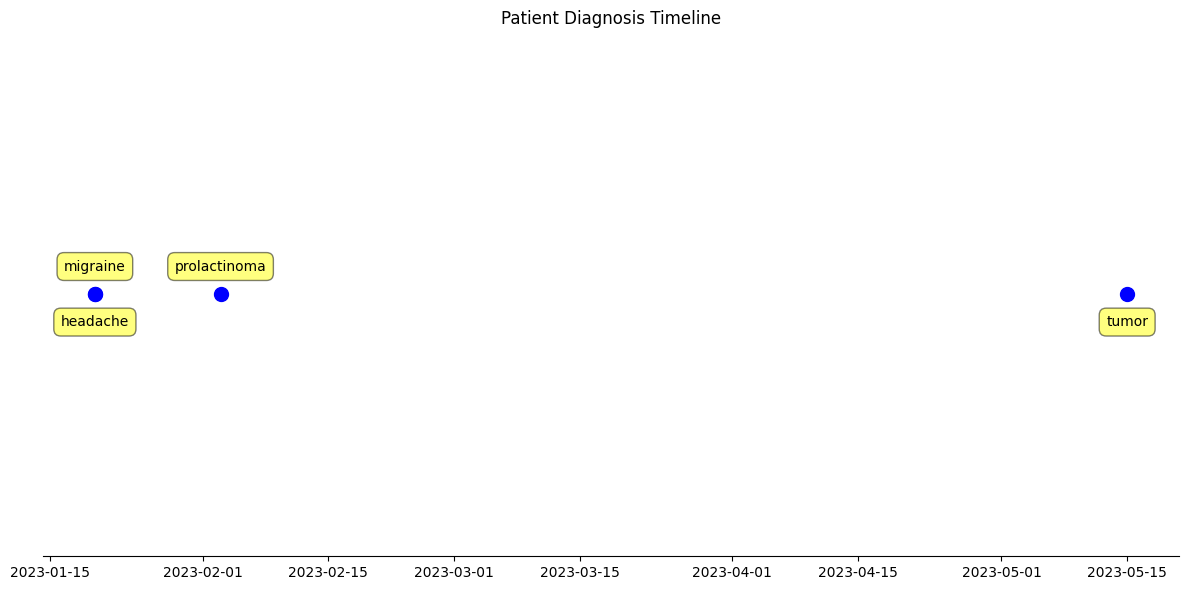

In [11]:
def visualize_timeline(timeline_entries):
    if not timeline_entries:
        print("No timeline entries to visualize")
        return
    
    # Prepare data for visualization
    dates = [entry[0] for entry in timeline_entries]
    diagnoses = [entry[1] for entry in timeline_entries]
    
    # Convert to pandas series for easier plotting
    timeline_df = pd.DataFrame({
        'date': dates,
        'diagnosis': diagnoses
    })
    
    # Plot the timeline
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot points for each diagnosis
    ax.scatter(timeline_df['date'], np.zeros_like(timeline_df['date']), s=100, color='blue')
    
    # Add diagnosis labels
    for i, (date, diagnosis) in enumerate(zip(timeline_df['date'], timeline_df['diagnosis'])):
        ax.annotate(diagnosis, 
                  xy=(date, 0),
                  xytext=(0, (-1)**i * 20),  # Alternate above/below to avoid overlap
                  textcoords='offset points',
                  ha='center',
                  va='center',
                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    # Format the plot
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.title('Patient Diagnosis Timeline')
    plt.tight_layout()
    plt.savefig('patient_diagnosis_timeline.png')
    plt.show()

# Visualize the timeline
visualize_timeline(timeline_entries)